In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import tcvx21
import numpy as np

In [2]:
from tcvx21 import read_struct_from_file, summarise_tree_dict

gbs = {}
gbs['reversed_field'] = read_struct_from_file(Path('simulation_data/GBS_REVB_Nov22.mat'))
gbs['forward_field'] = read_struct_from_file(Path('simulation_data/GBS_FWDB_Nov22.mat'))

summarise_tree_dict(gbs)

 -> reversed_field
  -> FHRP
   -> observables
    -> density
    -> electron_temp
    -> ion_temp
    -> potential
    -> jsat
    -> jsat_std
    -> jsat_skew
    -> jsat_kurtosis
    -> vfloat
    -> vfloat_std
    -> mach_number
  -> TS
   -> observables
    -> density
    -> electron_temp
    -> ion_temp
  -> RDPA
   -> observables
    -> density
    -> electron_temp
    -> ion_temp
    -> potential
    -> jsat
    -> jsat_std
    -> jsat_skew
    -> jsat_kurtosis
    -> vfloat
    -> vfloat_std
    -> mach_number
  -> LFS_LP
   -> observables
    -> density
    -> electron_temp
    -> ion_temp
    -> potential
    -> current
    -> current_std
    -> jsat
    -> jsat_std
    -> jsat_skew
    -> jsat_kurtosis
    -> vfloat
    -> vfloat_std
  -> LFS_IR
   -> observables
    -> q_parallel
  -> HFS_LP
   -> observables
    -> density
    -> electron_temp
    -> ion_temp
    -> potential
    -> current
    -> current_std
    -> jsat
    -> jsat_std
    -> jsat_skew
    -> jsat_kurtos

In [3]:
from tcvx21 import read_from_json

standard_dictionary = {
    'forward_field': read_from_json(tcvx21.template_file),
    'reversed_field': read_from_json(tcvx21.template_file)
}

simulation_hierarchy = read_from_json(Path('simulation_data/simulation_hierachy.json'))

In [4]:
from tcvx21.units_m import Quantity, Dimensionless

def flatten_arrays(entry):
    
    values = entry['values']
    errors = np.zeros_like(entry['values'])
    Ru = entry['Ru']
    Zx = entry['Zx']

    shape = Ru.shape

    # Broadcast Zx to 2D
    Zx = np.broadcast_to(Zx[:, np.newaxis], shape)

    # Check all arrays match
    arrays_match = np.all([array.shape == shape for array in [values, Ru, Zx]])
    if not arrays_match:
        print(f"Array shapes do not match. Shapes were values: {values.shape}, errors: {errors.shape}, Ru: {Ru.shape}, Zx: {Zx.shape}")
    
    return np.ravel(values), np.ravel(errors), np.ravel(Ru), np.ravel(Zx), arrays_match
    

def process_entry(field_direction, diagnostic, measurement):
    
    entry = gbs[field_direction][diagnostic.replace('-', '_')]['observables'][measurement]
    output = standard_dictionary[field_direction][diagnostic]['observables'][measurement]
    
    units_in = Quantity(entry['units']) if entry['units'] else Dimensionless
    units_out = Quantity(output['units']) if output['units'] else Dimensionless
    
    assert units_in.check(units_out)
    
    output['simulation_hierarchy'] = simulation_hierarchy[measurement]
    
    if output['dimensionality'] == 1:
        
        assert Quantity(entry['Ru_units']).check(Quantity(output['Ru_units']))
    
        output['values'] = entry['values']
        output['errors'] = entry['errors']
        output['Ru'] = entry['Ru']
    
    elif output['dimensionality'] == 2:
        
        assert Quantity(entry['Ru_units']).check(Quantity(output['Ru_units']))
        assert Quantity(entry['Zx_units']).check(Quantity(output['Zx_units']))
        
        try:
            values, errors, Ru, Zx, arrays_match = flatten_arrays(entry)
            if not arrays_match:
                print(f"Skipping {field_direction}:{diagnostic}:{measurement}")
            else:
                output['values'], output['errors'], output['Ru'], output['Zx'] = values, errors, Ru, Zx
        except ValueError:
                print(f"Skipping {field_direction}:{diagnostic}:{measurement}")
    
    else:
        raise NotImplementedError()

for field_direction, fd_dict in standard_dictionary.items():
    for diagnostic, d_dict in fd_dict.items():
        for measurement, m_dict in d_dict['observables'].items():
            
            process_entry(field_direction, diagnostic, measurement)

/var/folders/_s/10lb2_b164b_w7dsfq07njbr0000gn/T/ipykernel_67479/1046079849.py:28: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  units_in = Quantity(entry['units']) if entry['units'] else Dimensionless


In [5]:
from tcvx21.record_c import RecordWriter

for field_direction_ in ['forward_field', 'reversed_field']:

    writer = RecordWriter(file_path=Path(f'GBS_{field_direction_}.nc'),
                 descriptor='GBS',
                 description=Path(f'simulation_data/GBS_{field_direction_}_description.txt').read_text(),
                 allow_overwrite=True)

    writer.write_data_dict(standard_dictionary[field_direction_])

Overwriting GBS_forward_field.nc
Overwriting GBS_reversed_field.nc


Failed to plot forward_field:RDPA:ion_temp
Failed to plot reversed_field:RDPA:ion_temp


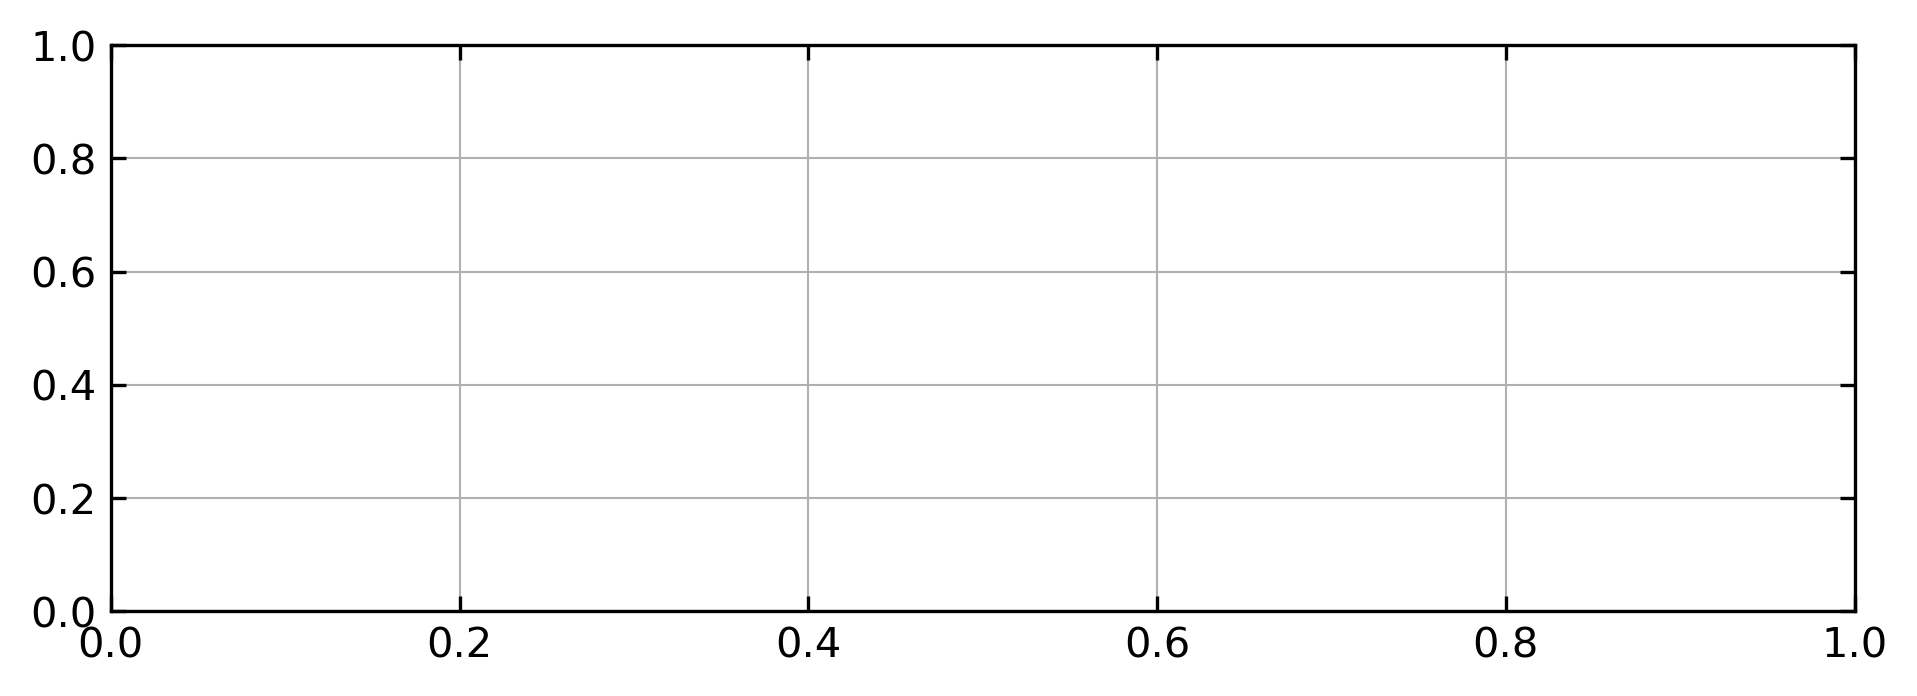

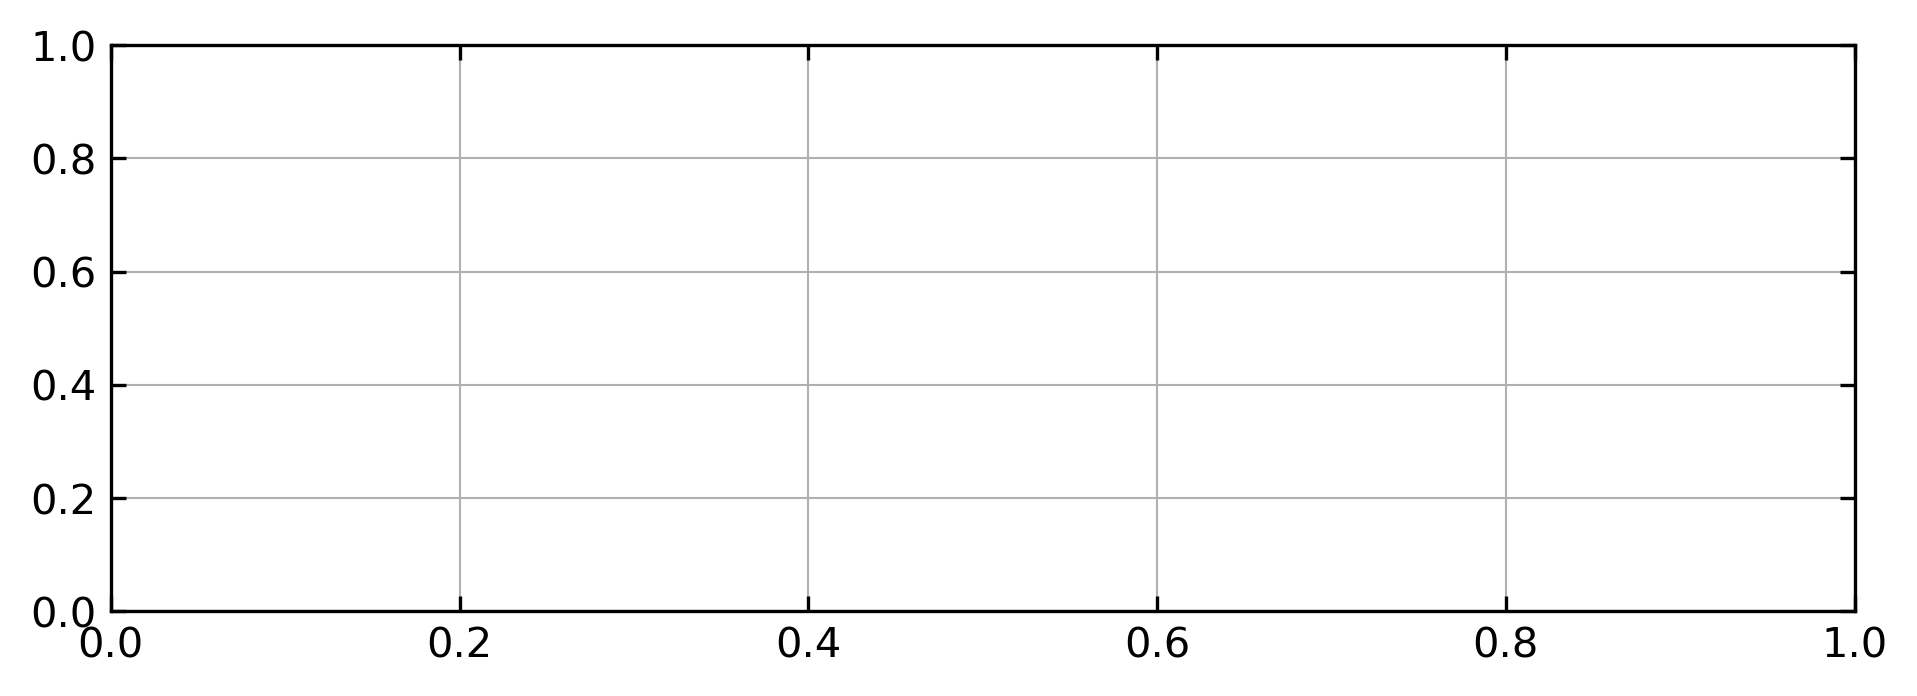

In [6]:
import tcvx21
import matplotlib.pyplot as plt
plt.style.use(tcvx21.style_sheet)
from tcvx21.record_c import Record

from tcvx21.plotting.plot_comparison_m import plot_comparison

experimental_data = {'forward_field': Record(tcvx21.experimental_reference_dir/"TCV_forward_field.nc", color='C0'),
       'reversed_field': Record(tcvx21.experimental_reference_dir/"TCV_reversed_field.nc", color='C0'),
       }
simulation_data = dict(
    new = {'forward_field': Record("GBS_forward_field.nc", color='C2', label='new'),
           'reversed_field': Record("GBS_reversed_field.nc", color='C2', label='new'),
          })

for field_direction in ['forward_field', 'reversed_field']:
    
    for diagnostic, observable in simulation_data['new'][field_direction].keys():
        
        try:
            plot_comparison(field_direction, diagnostic, observable,
                            experimental_data=experimental_data,
                            simulation_data=simulation_data,
                            show=False,
                            output_path=Path(f"comparison/{field_direction}:{diagnostic}:{observable}")
                           )
        except:
            print(f"Failed to plot {field_direction}:{diagnostic}:{observable}")

plt.show()